# Iterative Closest Points (ICP)

## Problem statement

Given two point clouds $P=\{p_1, ..., p_m \}$, $Q=\{ q_1, ..., q_n \}$, find a rigid transformation 
$$T=\big(R,t\big)$$
with $R^TR=I$ such that energy $E$ is minimzed:

$$
E(R,t) = \sum_{p_i \in P} \sum_{q_i \in Q} w_{ij} 
\lVert p_i - (Rq_j + t) \rVert^2
$$

$w_{ij}$ is a weight indicating correspondence between $p_i$ and $q_j$


> **Theorem (Murty and Kabadi (1987))**
>
> If an optimization problem is non-convex, it is NP-hard. [1]

**Problem**: All of these energies are non-convex!

In general, we cannot efficiently calculate the global optimum. 
Instead we use **heuristics** to approximate it!

---

## ICP

Iterative-Closest-Point (ICP) is a registration algorithm to solve above-mentioned problem.

**Heuristic**: Assume...
* $\exists$ set of correspondences such that the optimal alignment of this set is also optimal for the whole problem
* the weights are binary: $w_{ij} \in \{0, 1\}$
* one can "decouple correspondence optimization from transformation optimization"

**Idea**: Similar to k-means, iterate:
* optimize correspondeces and keep $T=\big(R,t\big)$ fixed...
* then optimize $T=\big(R,t\big)$ and keep correspondences fixe

$\rightarrow$ Gradient descent for following energy:
$$
E(R,t) = \sum_{i=1}^n \lVert p_{c(i)} - \big(Rq_i + t \big) \rVert^2
$$

### Algorithm

* Start from approximate registration
* Repeat ..
    * Identify corresponding points $(q_i, p_{c(i)})$
    * Compute and apply optimal rigid transformation $T=\big(R,t\big)$ until registration error (point-to-point distance) is small: 
    $E(R,t) < \delta_{\mathrm{threshold}}$

**Problem**: how to compute an optimal transformation $T=\big(R,t\big)$ out of the correspondences?

> **Theorem (Center of Mass)**
>
> If $T=\big(R,t\big)$ is optimal transformation, then the correspondance $\{p_{c(i)} \}$ and $\{Rq_i +t \}$ have the same center of mass, i.e.
> $$\overline{p} = \frac{1}{n} \sum_{i=1}^n p_{c(i)} = 
\frac{1}{n} \sum_{i=1}^n \big(Rq_i + t \big) = R\overline{q} + t$$



> **Lemma (Least Squares Distance Minimizer)**
>
> Let $\{x_i \}$ be a set of points and 
$\overline{x}=\frac{1}{n} \sum_{i=1}^n x_i$ be their center of mass. Then $\overline{x}$ minimizes the following energy:
> $$E(x)=\sum_{i=1}^n \lVert x - x_i \rVert^2$$

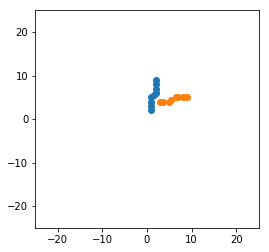

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

P = np.array([
    [1, 2],[1, 3],[1, 4],[1, 5],[1.5, 5.5],[2, 6],[2, 7],[2, 8],[2, 9]
])
Q = np.array([
    [3, 4],[3.5, 4],[5, 4],[5.5, 4.5],[6.5, 5],[7, 5],[8, 5],[9, 5]
])

def p_com():
    return np.mean(P, 0)

def q_com():
    return np.mean(Q, 0)

def p_c(i):
    q = Q[i]
    closest = 999
    cosest_p = None
    for p in P:
        dist = np.linalg.norm(p-q)
        if dist < closest:
            closest = dist
            closest_p = p
    assert closest_p is not None
    return closest_p

n = Q.shape[0]


fig = plt.figure(figsize=(4, 4))
def plot_pq(ax):
    ax.set_xlim([-25, 25])
    ax.set_ylim([-25, 25])
    ax.scatter(P[:,0], P[:,1])
    ax.scatter(Q[:,0], Q[:,1])
    

plot_pq(fig.add_subplot(111))
plt.show()

$$
t = \frac{1}{n} \sum_i^n \big( 
p_{c(i)} - Rq_i
\big) = \overline{p} - R\overline{q}
$$

$$
H = \sum_i^n q'_i p_{c(i)}^{'T}
$$
$$H=U\Sigma V^T$$
$$R:= VU^T$$

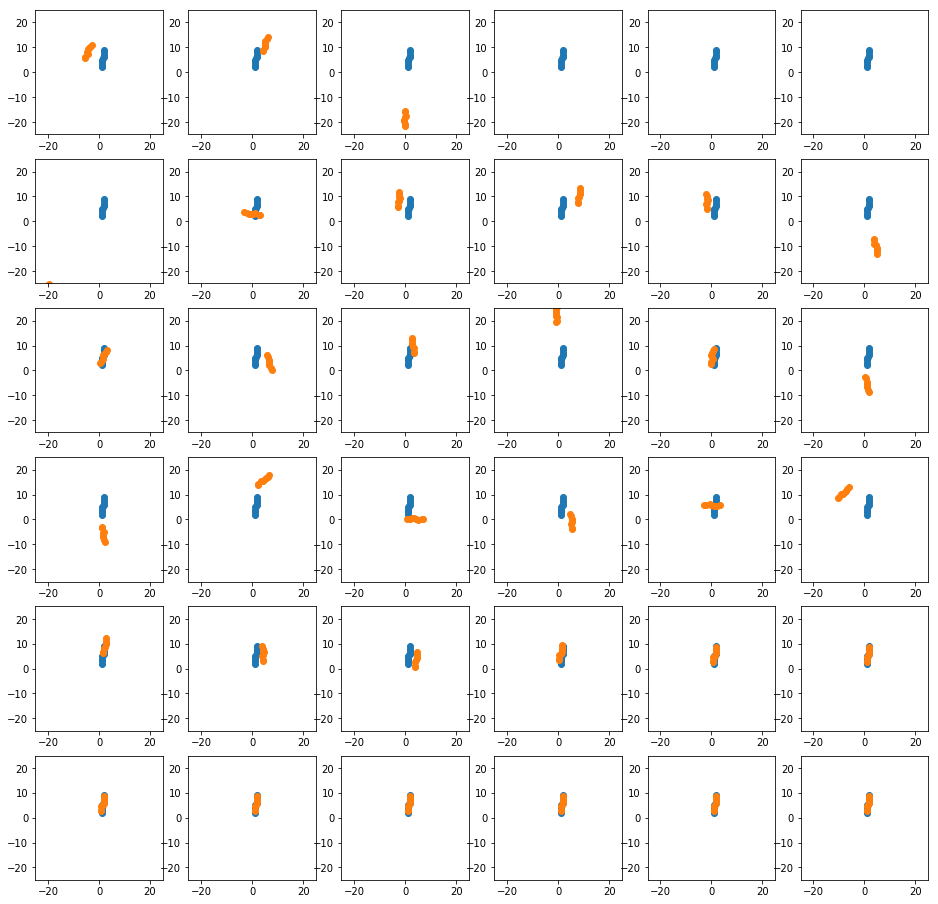

In [2]:
from numpy import atleast_2d as vec
from numpy.linalg import svd

R = np.eye(2)

def predict_transform(R):
    t = p_com() - R @ q_com()
    H = np.sum([
        vec(Q[i] - q_com()).T @ vec(p_c(i) - p_com()) \
            for i in range(n)], 0)
    u,s,v = svd(H)
    R = v@u.T
    return R, t

def predict_step(R):
    global Q
    R, t = predict_transform(R)
    Q = np.array([R@Q[i] + t for i in range(n)])
    return R

fig = plt.figure(figsize=(16,16))

s = 6
for i in range(s**2):
    R = predict_step(R)
    plot_pq(fig.add_subplot(s, s, i+1))



plt.show()

## References

[1] Murty, Katta G., and Santosh N. Kabadi. "Some NP-complete problems in quadratic and nonlinear programming." Mathematical programming 39.2 (1987): 117-129.